# Punto 1 - Taller 1

<b>Desarrolldo Por:</b>
* Juan Camilo
* Diego
* Ricardo

In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_profiling 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# Procesamiento del lenguaje Natural
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [2]:
def plot_matriz_confusion(y_test, y_pred):
    array = confusion_matrix(y_test, y_pred)
    filas = array.shape[0]
    colunas = array.shape[1]
    df_cm = pd.DataFrame(array, index = [i for i in range(filas)],
                  columns = [i for i in range(colunas)])
    plt.figure(figsize = (8,4))
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=True,fmt='g')
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
def make_report(estimator,X_test,y_test, classes):
    y_pred = estimator.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, classes)
    #plot_matriz_confusion(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report["accuracy"] = estimator.score(X_test, y_test)
    return df_report.iloc[:5,:]

## 1. Carga del Dataset

## - Carga del conjunto de datos

In [4]:
df = pd.read_csv("Documentos_proyectos.csv", sep =",", encoding="latin")
df.rename({"TEXTO;;;;;;;":"TEXTO"},axis = 1, inplace=True)
df["TEXTO"] = df["TEXTO"].apply(lambda x: x.replace(";;;;;;;",""))

Debido a la codiicación empleada para el conjunto de datos, el valor del parametro encoding debe ser "latin". 

In [5]:
df.head

<bound method NDFrame.head of                                                MENCION  \
0                                APLICACIONES INTERNET   
1                                APLICACIONES INTERNET   
2                                APLICACIONES INTERNET   
3                                APLICACIONES INTERNET   
4                                APLICACIONES INTERNET   
..                                                 ...   
220  TECNOLOGIAS EN COMUNICACIONES Y REDES DE COMPU...   
221  TECNOLOGIAS EN COMUNICACIONES Y REDES DE COMPU...   
222  TECNOLOGIAS EN COMUNICACIONES Y REDES DE COMPU...   
223  TECNOLOGIAS EN COMUNICACIONES Y REDES DE COMPU...   
224  TECNOLOGIAS EN COMUNICACIONES Y REDES DE COMPU...   

                                                 TEXTO  
0    ACTUALIZACIÓN TECNOLÓGICA PARA EL INSTITUTO NA...  
1    CATÁLOGOS INTELIGENTES: UNA HERRAMIENTA PARA L...  
2    CENTRALIZACIÓN Y ESTANDARIZACIÓN DE LA AUTENTI...  
3    CONSTRUCCIÓN DE UNA APLICACIÓN WEB BAJO 

## - Carga del Diccionario de Palabras

In [6]:
df_stops = pd.read_table("DiccionarioPalabrasVacias.txt")
otras_stopwords = df_stops["STOP_WORDS"].values
len(otras_stopwords)

345

## 2. Exploración Inicial

In [7]:
df.head()

,MENCION,TEXTO
0,APLICACIONES INTERNET,ACTUALIZACIÓN TECNOLÓGICA PARA EL INSTITUTO NA...
1,APLICACIONES INTERNET,CATÁLOGOS INTELIGENTES: UNA HERRAMIENTA PARA L...
2,APLICACIONES INTERNET,CENTRALIZACIÓN Y ESTANDARIZACIÓN DE LA AUTENTI...
3,APLICACIONES INTERNET,CONSTRUCCIÓN DE UNA APLICACIÓN WEB BAJO LA ARQ...
4,APLICACIONES INTERNET,DESARROLLO DE LA APLICACIÓN DE GESTIÓN ACADÉMI...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 2 columns):
MENCION    225 non-null object
TEXTO      225 non-null object
dtypes: object(2)
memory usage: 3.6+ KB


## - Inspección de la proporción de las Clases

BASE DE DATOS                                            57
APLICACIONES INTERNET                                    56
TECNOLOGIAS EN COMUNICACIONES Y REDES DE COMPUTADORAS    51
INTELIGENCIA ARTIFICIAL                                  46
SISTEMAS DE INFORMACION                                  15
Name: MENCION, dtype: int64


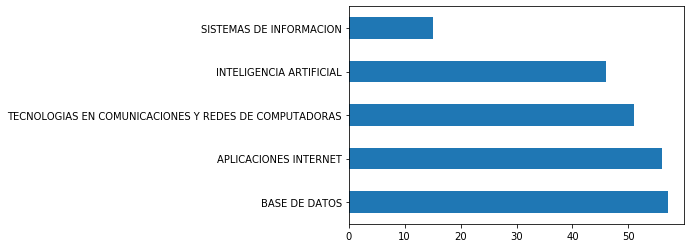

In [9]:
print(df["MENCION"].value_counts())
df["MENCION"].value_counts().plot(kind="barh");

In [10]:
print(df["MENCION"].value_counts()/df["MENCION"].sum())

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Calramente existeun desbalance siginicatvo en entre la case "SISTEMAS DE INFORMACIÓN" y las demas clases.

## - Cambio de etiquetas

In [11]:
le = LabelEncoder()
le.fit(df["MENCION"].unique())
df["MENCION"] = le.transform(df["MENCION"].values)

In [12]:
etiquetas = np.array([0,1,2,3,4])
etiquetas = le.inverse_transform(etiquetas)
etiquetas

array(['APLICACIONES INTERNET', 'BASE DE DATOS',
       'INTELIGENCIA ARTIFICIAL', 'SISTEMAS DE INFORMACION',
       'TECNOLOGIAS EN COMUNICACIONES Y REDES DE COMPUTADORAS'],
      dtype=object)

---

## - Definición de: X & y

In [13]:
X = df["TEXTO"]
y = df["MENCION"]

## - Train-Test Estratificada 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

## - Creación de Clase Vectorizador 
<b>Objetivo:</b> Desarrollar el preprocesamiento y transformación de la misma forma que lo hace sklearn y poder ejecutar los procesos de transformación al interior de un "Pipeline".

In [15]:
X_train.head()

12     DESARROLLO DE UN SISTEMA WEB PARA LA ADMINISTR...
45     METODOLOGÍA PARA LA AUDITORÍA DE SEGURIDAD DE ...
11     DESARROLLO DE UN SISTEMA WEB DE GESTIÓN  CONTR...
127    HERRAMIENTA DE MINERÍA DE DATOS: PROTOTIPO DEL...
44     IMPLEMENTACIÓN Y ESPECIFICACIÓN DE UNA HERRAMI...
Name: TEXTO, dtype: object

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

class MiVectorizador(BaseEstimator, TransformerMixin):
    """
    Desarrollada por:
        Juan Camilo Cática
    
    Esta clase permite trasformar colecciones de textos al formato vectorial que se define a 
    través de los parametros del método constructor.
    
    Esta clase desarrolla lematización por defecto sobre el conjunto de datos (Textos)
    """
    
    def __init__(self, tipo_vectores, idioma="spanish", stop_words_lem = False , add_stop_words =list()):
        """
        Iniialización de la clase "Vectorizador", la cual permite trasformar colecciones de textos al formato
        vectorial que se define a través de los parametros de este método.
        
        --------------------
        
        :Parametros
        
            - tipo_vetores: "binario", "gauss", "multinomial"
                "binario": Durante la trasformación se generan vectores binarios de palabras en 
                           representación de la colección de documentos.
                
                "gauss": Durante la trasformación se generan vectores de palabras en representación 
                         de documentos bajo la aplicación de la técnica TF-IDF.
                
                "multinomial": Durante la trasformación se generan vectores de palabras en representación de
                               los documentos por medio de fecuencias absolutas.
                    
            - idioma: str, default = "spanish"
                Idioma del lematizador intacia de la clase SnowballStemmer.
                Si el valor de idioma es igual a 'None' no se emplea lematización durante la tranformación.
                
            - stop_words_lem: True o False
                Determina si se incluye o no el conjunto de stop_words del lematizador.
                
            - add_stop_words: list, defoult = list()
                Este parametro recive la lista de stop_words que se adicionarán al conjuto de stop_words
                nltk.corpus.stopwods.
        """
        if tipo_vectores not in ["binario", "gauss", "multinomial"]:
            raise Exception("""Unicamente se aceptan los siguientes valores para el parametro 'tipo_vectores'
                               'binario', 'gauss', 'multinomial'""")
        
        self.tipo_vectores = tipo_vectores
        swnltk = set(stopwords.words(idioma)) if stop_words_lem else set()
        swprop = set(add_stop_words) 
        self.stop_words = list(swnltk.union(swprop)) 
        self.idioma = idioma
        self.lematizador = SnowballStemmer(idioma)
        self.tfidfvect = None
        
    def _preprocesar(self, X):
        """
        Este metodo se desarrolla en 6 estapas, las cuales son:
         1. Conversion a minusculas de la colección de textos que llegan a través del parametro.
         2. Eliminación de los signos de puntuación.
         3. Tokenización.
         4. Eliminación de stop words.
         5. Lematización de las palabras.
         6. Union de las palabras en una cadena de texto.
         
        --------------------
        
        :Parametros
        
            - X: list o DataFrame.Series
                 Este parametro contiene una colección de los texto que se requieren procesar.
        
        --------------------
        
        Importante:
        
        La eliminación de las StopWords se desarrolla en la etapa 4 y no se emplea la eliminación 
        durante la creación del Objeto <b>vecorizer</b> de la clase <b>TfidfVectorizer</b>. 

        Se desarrolla esta eliminación por medio de la etapa 4 debido a que se puedo haber realizado
        una unión entre el conjunto de stopwords entregadas a través del parametro "add_stop_words" junto
        con aquellas que se encuentran diponibles en NLTK, por tanto <b>SnowballStemmer</b> (NLTK) 
        al momneto de lematizar ignorando las stopwords puede cometer errores con aquellas que vienen 
        junto definido por medio de "add_stop_words" en el método constructor.
        """
        if type(X)==list:
            X = pd.Series(X)
        texto_preprocesado = X.apply(lambda x: x.lower())
        texto_preprocesado = texto_preprocesado.apply(lambda x: re.sub(r'[^\w\s]','',x))
        texto_preprocesado = texto_preprocesado.apply(lambda x: word_tokenize(x))
        texto_preprocesado = texto_preprocesado.apply(lambda x: [w for w in x if w not in self.stop_words])
        texto_preprocesado = texto_preprocesado.apply(lambda x: [self.lematizador.stem(i) for i in x])
        texto_preprocesado = texto_preprocesado.apply(lambda x: " ".join(x))
        return texto_preprocesado
    
    def fit(self, X, y=None):
        """
        Este metodo ejecuta crea la instancia de la clase "TfidfVectorizer" según se define a través de 
        los parametros de entrada del método constructor de esta clase.
        
        Posteriormente se ejecuta la etapa de preprocesamnto a través del método "self._preprocesar" y 
        se alimeta la instancia de la clase "TfidfVectorizer" previamente definida.
        
        --------------------
        
        :Parametros
        
            - X: list o DataFrame.Series
                 Este parametro contiene una colección de los texto que se requieren procesar.
            
            - y: None
                 Este parametro no se emplea durante el proceso de transformación. Proviene del metodo "tranform"
                 de la superclase.
                 
        NOTA: Revisar parametro "stop_words", ya que se han eliminado las stop_words en etapas anteriores
        """
        if self.tipo_vectores == "binario":
             self.tfidfvect = TfidfVectorizer(stop_words=self.stop_words, 
                                              binary=True, use_idf = False, norm = None)
        elif self.tipo_vectores == "gauss":
            self.tfidfvect = TfidfVectorizer(stop_words=self.stop_words)
        elif self.tipo_vectores == "multinomial":
            self.tfidfvect = TfidfVectorizer(stop_words=self.stop_words, 
                                             binary=False, use_idf = False, norm = None)
        else:
            raise Exception("""Unicamente se aceptan los siguientes valores para el parametro 'tipo_vectores'
                               'binario', 'gauss', 'multinomial'""")
        self.tfidfvect.fit(self._preprocesar(X))
        return self
    
    def transform(self, X, y=None):
        """
        Este metodo transforma la colección de datos que entran como parametro a una representación vectorial 
        definida por los atrbutos de clase que se establecen durante la creación de instancias de esta clase.
        
        --------------------
        
        :Parametros
        
            - X: list o DataFrame.Series
                 Este parametro contiene una colección de los texto que se requieren procesar.
            
            - y: None
                 Este parametro no se emplea durante el proceso de transformación. Proviene del metodo 
                 "transform" de la superclase.
        """
        return self.tfidfvect.transform(self._preprocesar(X)).toarray()
    
    def get_feature_names(self):
        """
        Este método retorna las palabras almacenadas en la instancia "self.tfidfvect" que se generan durante el
        preproesamiento desarrollado en la ejecución del metodo "self.fit()", es decir, estas palabras se 
        encuentran lematizadas, con eliminación de signos de puntuación y totalmente en minusculas.
        """
        if self.tfidfvect:
            return self.tfidfvect.get_feature_names()
        else:
            print("No se ha ejecutado 'self.fit()'")
            
    def info(self):
        vect_definido = "Definido" if self.tfidfvect else "No Definido, Sin entrenar (Sin ejecución de fit())"
        sub_msn = ""
        if self.tfidfvect:
            sub_msn = f"""
            -----------------------------------------
                Modelo
                Total de Palabras (features): {len(self.tfidfvect.get_feature_names())}"""
        msn = f"""
            Vectorizado TfIdfVect  : {vect_definido}
            Tipo de vectores       : {self.tipo_vectores}
            Total de stopwords     : {len(self.stop_words)}
            Idioma del lematizador : {self.idioma}
            {sub_msn}"""
        print(msn)

## - Test de la Calse Creada : Prueba multinomial

In [17]:
mi_vectorizador = MiVectorizador("multinomial", stop_words_lem =True, add_stop_words=otras_stopwords)
X = mi_vectorizador.fit_transform(X=df["TEXTO"])
X.shape

(225, 3319)

In [23]:
df["TEXTO"].type()

AttributeError: 'Series' object has no attribute 'type'

In [20]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
mi_vectorizador.info()


            Vectorizado TfIdfVect  : Definido
            Tipo de vectores       : multinomial
            Total de stopwords     : 517
            Idioma del lematizador : spanish
            
            -----------------------------------------
                Modelo
                Total de Palabras (features): 3319


#### Análisis: Conjunto de Palabras Original

In [16]:
conjuto_palabras = set()
agg = lambda x : conjuto_palabras.update(x)
df["TEXTO"].apply(lambda x: agg(set(re.sub(r'[^\w\s]','',x).lower().split(" "))));
print("Tamaño del conjuto de palabras orginal (Corpus):",len(conjuto_palabras))

Tamaño del conjuto de palabras orginal (Corpus): 6194


## Análisis

Se puede observar que se disminuye notoriamente el número de variales (palabras) por medio de la elimnaión de stopwords duante la etapa de preprocesamiento que se desarrolla durante la ejecución del método fit de la clase <b>MiVectorizador</b>.

Se eliminan 4093 palabras!

<b>Importante:</b> Recordar que si al momento de instanciar <b>MiVectorizador</b> no se agregan nuevas stopwords, la instancia de <b>MiVectorizador</b> eliminara stopwords definidas en por <b>NLTK</b>. Es decir que siempre se dearrollará eliminación de stopwrds mediante <b>MiVectorizador</b>.

------

# Estimadores Bayesianos

En las siguientes lineas se desarrolla el entrenamiento y evaluación de 3 clasificadores Bayesiano. Para cada uno de ellos se lleva a cab el siguiente procedimiento:

1. Se crea una instancia de la clase "MiVectorizador", en la cual se añaden las "stopwords" suministradas en el enunciado del problema. Adiconalmente se definen otros parametros como el tipo de vectores deseados, con el fin de entrenar posteriormente cada uno de los diferentes estimadores de manera adecuada en función de sus requerimientos.

2. Se desarrolla la transformación unicamente del conjunto de entrenamento. 
    
    En este paso la instancia de "MiVectorizador" internamente crea una instancia de "Sklearn.TfIdfVectorizer" y la almacena, de tal forma que al momento de desarrollar futuras transformaciones ese objeto ya ha almacenado valores necesarios, como es el caso de "Idf" cuando el valor de "tipo_vectores" es igual a "gauss", para el estiador "GaussianNB".

3. se crea una instancia del estimador bayesiano deseado.

4. Se entrena el estimador bayesiano

5. Se toma el conjunto de test y se transforma con ayuda de la instancia previamente creada de "MiVectorizador"

6. Se desarrolla la prueba.


In [17]:
import warnings
warnings.filterwarnings('ignore')

## - Bernoulli NB

### Train

In [18]:
mivect_binario =  MiVectorizador("binario", stop_words_lem =True, add_stop_words=otras_stopwords)
Bin_X_train = mivect_binario.fit_transform(X_train.copy())
bernoulliNB = BernoulliNB()
bernoulliNB.fit(Bin_X_train, y_train);

### Test

In [19]:
Bin_X_test = mivect_binario.transform(X_test.copy())
bernoulliNB.score(Bin_X_test,y_test)

0.8444444444444444

Confusion matrix, without normalization


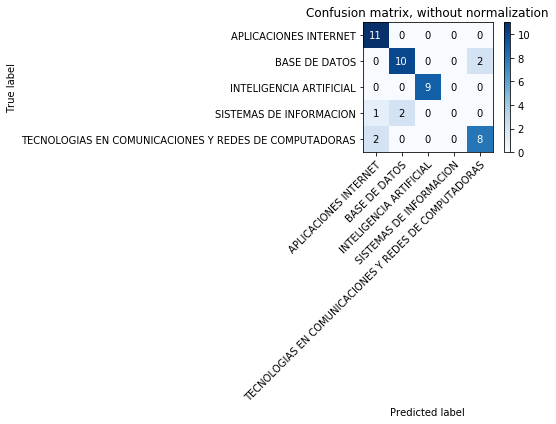

In [20]:
binNB_report = make_report(bernoulliNB, Bin_X_test, y_test.values, etiquetas)

In [21]:
print(classification_report(y_test, bernoulliNB.predict(Bin_X_test)))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       0.83      0.83      0.83        12
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         3
           4       0.80      0.80      0.80        10

   micro avg       0.84      0.84      0.84        45
   macro avg       0.68      0.73      0.70        45
weighted avg       0.79      0.84      0.82        45



## - GaussianNB

### Train

In [22]:
mivect_gauss =  MiVectorizador("gauss", stop_words_lem =True, add_stop_words=otras_stopwords)
Gauss_X_train = mivect_gauss.fit_transform(X_train.copy())
gausNB = GaussianNB()
gausNB.fit(Gauss_X_train, y_train);

### Test

In [23]:
Gauss_X_test = mivect_gauss.transform(X_test.copy())
gausNB.score(Gauss_X_test,y_test)

0.6444444444444445

Confusion matrix, without normalization


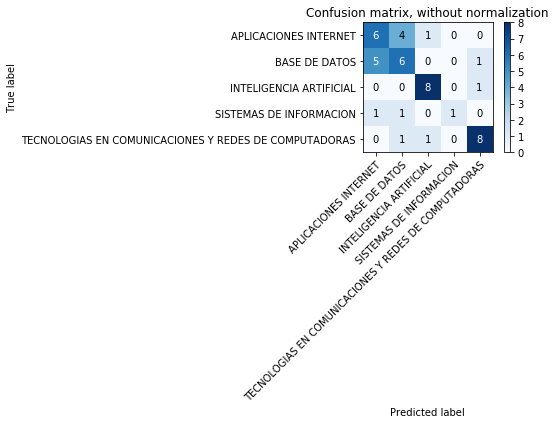

In [24]:
gausNB_report = make_report(gausNB, Gauss_X_test, y_test.values, etiquetas)

In [25]:
print(classification_report(y_test, gausNB.predict(Gauss_X_test)))

              precision    recall  f1-score   support

           0       0.50      0.55      0.52        11
           1       0.50      0.50      0.50        12
           2       0.80      0.89      0.84         9
           3       1.00      0.33      0.50         3
           4       0.80      0.80      0.80        10

   micro avg       0.64      0.64      0.64        45
   macro avg       0.72      0.61      0.63        45
weighted avg       0.66      0.64      0.64        45



## - MultinomialNB

### Train

In [26]:
mivect_multinomial =  MiVectorizador("multinomial", stop_words_lem =True, add_stop_words=otras_stopwords)
Mult_X_train = mivect_multinomial.fit_transform(X_train.copy())
multinomialNB = MultinomialNB()
multinomialNB.fit(Mult_X_train, y_train);

### Test

In [27]:
Mult_X_test = mivect_multinomial.transform(X_test.copy())
multinomialNB.score(Mult_X_test,y_test)

0.8666666666666667

Confusion matrix, without normalization


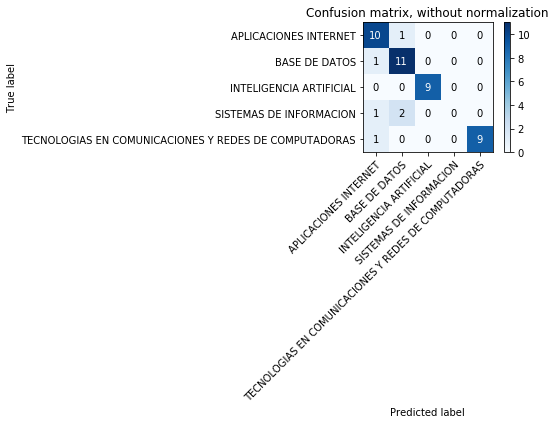

In [28]:
multiNB_report = make_report(multinomialNB, Mult_X_test, y_test.values, etiquetas)

-----

In [29]:
print(classification_report(y_test, multinomialNB.predict(Mult_X_test)))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.79      0.92      0.85        12
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         3
           4       1.00      0.90      0.95        10

   micro avg       0.87      0.87      0.87        45
   macro avg       0.71      0.75      0.73        45
weighted avg       0.82      0.87      0.84        45



----

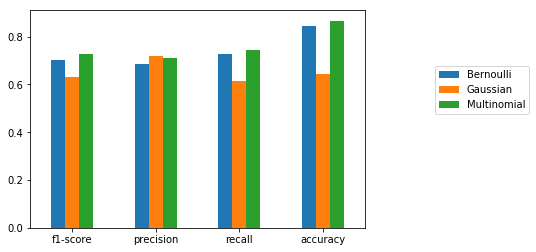

In [36]:
df = pd.DataFrame({
        'Bernoulli': binNB_report.mean(),
        'Gaussian': gausNB_report.mean(),
        'Multinomial': multiNB_report.mean(),
    }, index = multiNB_report.mean().index)
df.drop(["support"],axis = 0, inplace=True)
ax = df.plot.bar(rot=0)
plt.legend(loc=8, bbox_to_anchor=(0, 0.5, 2.7, 0.5))

## Interpretación

Como se puede observar claramente en las pruebas desarroldas para cada uno de los estimadores y en la gráfica anterior,  el mejor de ellos es el multinomial, donde se implementa unicamente la frecuancia absoluta de cada palabra en los diferentes documentos.

Otro de los aspectos mas importantes es la dificultad para desarrollar predicciones correctas sobre la clase "SISTEMAS DE INFORMACIÓN", esto se debe al claro desbalance que existe en el conjunto de datos, ya que el número de instancias de esta clase representa tan solo 3.75 % del conjunto de datos con 5 etiquetas posibles.

Para el estimador Gausiano es interesante ver como las clases "BASES DE DATOS" y "APLICACIONES INTERNET" tienen un alto grado de confusión. 


[Ver comentarios (Docstrings) de la clase "MiVectorizador" desarrollada para este proyecto]

-----

-----

### Adicional: Entendimiento "Weighted", "Macro", "Micro"

#### Weighted - precision

In [30]:
# Ponderado por el número de etiquetas
(multiNB_report["precision"]*multiNB_report["support"]).sum()/45

0.8197802197802198

#### Macro - precision

In [34]:
# Media de los valores por etiqueta sin ponderación
multiNB_report["precision"].mean()

0.7109890109890109

#### Micro - precision

In [32]:
# VP / (VP + (Misclassification))
39/(39+6)

0.8666666666666667